In [1]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features

In [2]:
dataset_path = 'data/data_speech_commands_v0.02'

In [3]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)

['zero', 'four', 'three', 'right', 'cat', 'tree', 'happy', 'one', 'wow', 'up', 'down', 'house', 'marvin', 'two', 'yes', 'nine', 'bird', 'learn', 'sheila', 'dog', 'bed', 'eight', 'on', 'stop', 'left', 'forward', 'six', 'off', 'visual', 'five', 'backward', 'go', 'no', 'seven', 'follow']


In [4]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

4052
3728
3727
3778
2031
1759
2054
3890
2123
3723
3917
2113
2100
3880
4044
3934
2064
1575
2022
2128
2014
3787
3845
3872
3801
1557
3860
3745
1592
4052
1664
3880
3941
3998
1579
Total samples: 105829


In [5]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.1
sample_rate = 8000
num_mfcc = 16
len_mfcc = 16

In [6]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

data/data_speech_commands_v0.02/zero
data/data_speech_commands_v0.02/four
data/data_speech_commands_v0.02/three
data/data_speech_commands_v0.02/right
data/data_speech_commands_v0.02/cat
data/data_speech_commands_v0.02/tree
data/data_speech_commands_v0.02/happy
data/data_speech_commands_v0.02/one
data/data_speech_commands_v0.02/wow
data/data_speech_commands_v0.02/up
data/data_speech_commands_v0.02/down
data/data_speech_commands_v0.02/house
data/data_speech_commands_v0.02/marvin
data/data_speech_commands_v0.02/two
data/data_speech_commands_v0.02/yes
data/data_speech_commands_v0.02/nine
data/data_speech_commands_v0.02/bird
data/data_speech_commands_v0.02/learn
data/data_speech_commands_v0.02/sheila
data/data_speech_commands_v0.02/dog
data/data_speech_commands_v0.02/bed
data/data_speech_commands_v0.02/eight
data/data_speech_commands_v0.02/on
data/data_speech_commands_v0.02/stop
data/data_speech_commands_v0.02/left
data/data_speech_commands_v0.02/forward
data/data_speech_commands_v0.02/six


In [7]:
# Check ground truth Y vector
print(y)
for item in y:
    print(len(item))

[array([0., 0., 0., ..., 0., 0., 0.]), array([1., 1., 1., ..., 1., 1., 1.]), array([2., 2., 2., ..., 2., 2., 2.]), array([3., 3., 3., ..., 3., 3., 3.]), array([4., 4., 4., ..., 4., 4., 4.]), array([5., 5., 5., ..., 5., 5., 5.]), array([6., 6., 6., ..., 6., 6., 6.]), array([7., 7., 7., ..., 7., 7., 7.]), array([8., 8., 8., ..., 8., 8., 8.]), array([9., 9., 9., ..., 9., 9., 9.]), array([10., 10., 10., ..., 10., 10., 10.]), array([11., 11., 11., ..., 11., 11., 11.]), array([12., 12., 12., ..., 12., 12., 12.]), array([13., 13., 13., ..., 13., 13., 13.]), array([14., 14., 14., ..., 14., 14., 14.]), array([15., 15., 15., ..., 15., 15., 15.]), array([16., 16., 16., ..., 16., 16., 16.]), array([17., 17., 17., ..., 17., 17., 17.]), array([18., 18., 18., ..., 18., 18., 18.]), array([19., 19., 19., ..., 19., 19., 19.]), array([20., 20., 20., ..., 20., 20., 20.]), array([21., 21., 21., ..., 21., 21., 21.]), array([22., 22., 22., ..., 22., 22., 22.]), array([23., 23., 23., ..., 23., 23., 23.]), arr

In [8]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [9]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [10]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

105829
105829


In [11]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [12]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [13]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [14]:
def signal_to_mfcc(signal, fs):
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [15]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    return signal_to_mfcc(signal, fs)

In [23]:
# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1

Dropped: 4 (16, 7)
Dropped: 22 (16, 14)
Dropped: 55 (16, 15)
Dropped: 75 (16, 13)
Dropped: 97 (16, 8)
Dropped: 139 (16, 12)
Dropped: 162 (16, 11)
Dropped: 165 (16, 14)
Dropped: 169 (16, 13)
Dropped: 182 (16, 13)
Dropped: 207 (16, 14)
Dropped: 208 (16, 15)
Dropped: 215 (16, 13)
Dropped: 216 (16, 15)
Dropped: 232 (16, 12)
Dropped: 235 (16, 11)
Dropped: 256 (16, 11)
Dropped: 271 (16, 11)
Dropped: 298 (16, 15)
Dropped: 318 (16, 11)
Dropped: 323 (16, 10)
Dropped: 344 (16, 4)
Dropped: 381 (16, 14)
Dropped: 390 (16, 10)
Dropped: 393 (16, 15)
Dropped: 405 (16, 12)
Dropped: 415 (16, 10)
Dropped: 432 (16, 13)
Dropped: 447 (16, 13)
Dropped: 451 (16, 12)
Dropped: 455 (16, 14)
Dropped: 460 (16, 15)
Dropped: 474 (16, 12)
Dropped: 477 (16, 11)
Dropped: 478 (16, 11)
Dropped: 492 (16, 13)
Dropped: 497 (16, 10)


In [24]:
print('% of problematic samples:', prob_cnt / 500)

% of problematic samples: 0.074


MFCCs: [[-6.28051528e+01 -6.24024067e+01 -6.20660460e+01 -6.17417182e+01
  -5.39688231e+01 -4.63132367e+01 -3.81119269e+01 -2.13340383e+01
  -1.27085615e+01 -1.03753981e+01 -1.24435977e+01 -1.79620956e+01
  -2.20185809e+01 -2.56211825e+01 -3.38853659e+01 -4.27436947e+01]
 [ 1.25107104e+00  6.63026002e-01  5.66615780e-01  6.47384464e-01
  -6.49488794e+00 -1.05971330e+01 -9.80005460e+00 -7.24989204e-01
   1.99445775e+00  3.27082359e+00  4.07458425e+00  5.46653363e+00
   4.56240351e+00  3.68885683e+00  2.49795168e+00  1.14468421e+00]
 [ 2.50338719e+00  2.64501109e+00  1.48486092e+00  1.91830977e+00
   5.84345548e+00  5.55055297e+00  3.61011023e+00  2.15605055e+00
  -1.00236164e+00 -3.02510032e+00 -3.34886141e+00 -1.84988280e+00
   1.13428157e+00  2.18877214e+00  3.25932917e+00  2.28841815e+00]
 [ 5.99413360e-01 -2.53753320e-01 -8.15011195e-01 -8.38967876e-01
  -2.16530912e+00 -1.94483352e+00 -3.52764015e+00 -3.63076919e+00
  -2.16034277e+00 -1.09006488e+00 -6.96302637e-01  3.37178583e-01


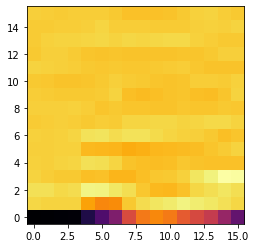

In [25]:
# TEST: Test shorter MFCC
# !pip install playsound
from playsound import playsound

idx = 13

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
playsound(path)

In [26]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [27]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Dropped: 4 (16, 7)
Dropped: 22 (16, 14)
Dropped: 55 (16, 15)
Dropped: 75 (16, 13)
Dropped: 97 (16, 8)
Dropped: 139 (16, 12)
Dropped: 162 (16, 11)
Dropped: 165 (16, 14)
Dropped: 169 (16, 13)
Dropped: 182 (16, 13)
Dropped: 207 (16, 14)
Dropped: 208 (16, 15)
Dropped: 215 (16, 13)
Dropped: 216 (16, 15)
Dropped: 232 (16, 12)
Dropped: 235 (16, 11)
Dropped: 256 (16, 11)
Dropped: 271 (16, 11)
Dropped: 298 (16, 15)
Dropped: 318 (16, 11)
Dropped: 323 (16, 10)
Dropped: 344 (16, 4)
Dropped: 381 (16, 14)
Dropped: 390 (16, 10)
Dropped: 393 (16, 15)
Dropped: 405 (16, 12)
Dropped: 415 (16, 10)
Dropped: 432 (16, 13)
Dropped: 447 (16, 13)
Dropped: 451 (16, 12)
Dropped: 455 (16, 14)
Dropped: 460 (16, 15)
Dropped: 474 (16, 12)
Dropped: 477 (16, 11)
Dropped: 478 (16, 11)
Dropped: 492 (16, 13)
Dropped: 497 (16, 10)
Dropped: 518 (16, 12)
Dropped: 528 (16, 7)
Dropped: 563 (16, 12)
Dropped: 574 (16, 15)
Dropped: 593 (16, 13)
Dropped: 597 (16, 10)
Dropped: 603 (16, 13)
Dropped: 611 (16, 8)
Dropped: 621 (16, 13)

Dropped: 4843 (16, 10)
Dropped: 4856 (16, 14)
Dropped: 4864 (16, 13)
Dropped: 4872 (16, 13)
Dropped: 4882 (16, 14)
Dropped: 4896 (16, 8)
Dropped: 4906 (16, 10)
Dropped: 4922 (16, 13)
Dropped: 4927 (16, 10)
Dropped: 4957 (16, 14)
Dropped: 4968 (16, 12)
Dropped: 4983 (16, 14)
Dropped: 4985 (16, 12)
Dropped: 5005 (16, 9)
Dropped: 5016 (16, 13)
Dropped: 5024 (16, 3)
Dropped: 5034 (16, 10)
Dropped: 5044 (16, 7)
Dropped: 5050 (16, 13)
Dropped: 5052 (16, 14)
Dropped: 5072 (16, 12)
Dropped: 5086 (16, 14)
Dropped: 5092 (16, 13)
Dropped: 5094 (16, 12)
Dropped: 5120 (16, 12)
Dropped: 5122 (16, 15)
Dropped: 5131 (16, 13)
Dropped: 5144 (16, 12)
Dropped: 5151 (16, 14)
Dropped: 5152 (16, 13)
Dropped: 5175 (16, 12)
Dropped: 5182 (16, 12)
Dropped: 5192 (16, 7)
Dropped: 5200 (16, 12)
Dropped: 5212 (16, 13)
Dropped: 5226 (16, 12)
Dropped: 5235 (16, 11)
Dropped: 5236 (16, 11)
Dropped: 5238 (16, 12)
Dropped: 5255 (16, 15)
Dropped: 5276 (16, 15)
Dropped: 5283 (16, 13)
Dropped: 5288 (16, 9)
Dropped: 5298 (16

Dropped: 9207 (16, 12)
Dropped: 9216 (16, 12)
Dropped: 9229 (16, 8)
Dropped: 9231 (16, 11)
Dropped: 9240 (16, 15)
Dropped: 9243 (16, 11)
Dropped: 9247 (16, 10)
Dropped: 9248 (16, 13)
Dropped: 9264 (16, 12)
Dropped: 9287 (16, 10)
Dropped: 9291 (16, 10)
Dropped: 9292 (16, 15)
Dropped: 9294 (16, 11)
Dropped: 9300 (16, 13)
Dropped: 9301 (16, 12)
Dropped: 9302 (16, 13)
Dropped: 9320 (16, 12)
Dropped: 9354 (16, 10)
Dropped: 9358 (16, 13)
Dropped: 9377 (16, 13)
Dropped: 9395 (16, 8)
Dropped: 9402 (16, 13)
Dropped: 9416 (16, 13)
Dropped: 9422 (16, 15)
Dropped: 9428 (16, 11)
Dropped: 9476 (16, 12)
Dropped: 9491 (16, 14)
Dropped: 9493 (16, 11)
Dropped: 9496 (16, 13)
Dropped: 9502 (16, 11)
Dropped: 9536 (16, 13)
Dropped: 9537 (16, 14)
Dropped: 9548 (16, 15)
Dropped: 9551 (16, 15)
Dropped: 9556 (16, 10)
Dropped: 9579 (16, 11)
Dropped: 9588 (16, 15)
Dropped: 9592 (16, 13)
Dropped: 9604 (16, 13)
Dropped: 9608 (16, 15)
Dropped: 9619 (16, 13)
Dropped: 9638 (16, 12)
Dropped: 9644 (16, 15)
Dropped: 9657

Dropped: 12863 (16, 13)
Dropped: 12868 (16, 8)
Dropped: 12888 (16, 10)
Dropped: 12908 (16, 13)
Dropped: 12911 (16, 10)
Dropped: 12914 (16, 15)
Dropped: 12925 (16, 13)
Dropped: 12934 (16, 13)
Dropped: 12949 (16, 11)
Dropped: 12975 (16, 8)
Dropped: 12984 (16, 13)
Dropped: 12991 (16, 7)
Dropped: 12999 (16, 7)
Dropped: 13002 (16, 14)
Dropped: 13006 (16, 11)
Dropped: 13020 (16, 6)
Dropped: 13024 (16, 15)
Dropped: 13032 (16, 10)
Dropped: 13044 (16, 14)
Dropped: 13046 (16, 8)
Dropped: 13049 (16, 12)
Dropped: 13065 (16, 11)
Dropped: 13070 (16, 14)
Dropped: 13073 (16, 14)
Dropped: 13074 (16, 15)
Dropped: 13084 (16, 14)
Dropped: 13097 (16, 12)
Dropped: 13099 (16, 11)
Dropped: 13113 (16, 10)
Dropped: 13128 (16, 13)
Dropped: 13133 (16, 7)
Dropped: 13134 (16, 14)
Dropped: 13155 (16, 12)
Dropped: 13170 (16, 13)
Dropped: 13193 (16, 15)
Dropped: 13198 (16, 11)
Dropped: 13202 (16, 10)
Dropped: 13208 (16, 11)
Dropped: 13214 (16, 12)
Dropped: 13215 (16, 8)
Dropped: 13226 (16, 13)
Dropped: 13234 (16, 11)


Dropped: 17137 (16, 12)
Dropped: 17138 (16, 15)
Dropped: 17184 (16, 15)
Dropped: 17191 (16, 12)
Dropped: 17202 (16, 15)
Dropped: 17245 (16, 10)
Dropped: 17261 (16, 13)
Dropped: 17265 (16, 12)
Dropped: 17268 (16, 15)
Dropped: 17282 (16, 13)
Dropped: 17285 (16, 8)
Dropped: 17288 (16, 13)
Dropped: 17299 (16, 14)
Dropped: 17312 (16, 11)
Dropped: 17317 (16, 8)
Dropped: 17327 (16, 15)
Dropped: 17333 (16, 15)
Dropped: 17335 (16, 12)
Dropped: 17336 (16, 14)
Dropped: 17341 (16, 14)
Dropped: 17369 (16, 12)
Dropped: 17373 (16, 15)
Dropped: 17380 (16, 10)
Dropped: 17403 (16, 15)
Dropped: 17408 (16, 15)
Dropped: 17409 (16, 11)
Dropped: 17412 (16, 13)
Dropped: 17433 (16, 14)
Dropped: 17449 (16, 11)
Dropped: 17456 (16, 12)
Dropped: 17467 (16, 14)
Dropped: 17468 (16, 14)
Dropped: 17482 (16, 12)
Dropped: 17507 (16, 12)
Dropped: 17519 (16, 13)
Dropped: 17532 (16, 14)
Dropped: 17534 (16, 8)
Dropped: 17535 (16, 14)
Dropped: 17538 (16, 13)
Dropped: 17548 (16, 15)
Dropped: 17552 (16, 14)
Dropped: 17563 (16,

Dropped: 21206 (16, 9)
Dropped: 21211 (16, 11)
Dropped: 21214 (16, 15)
Dropped: 21221 (16, 9)
Dropped: 21228 (16, 14)
Dropped: 21239 (16, 15)
Dropped: 21247 (16, 8)
Dropped: 21260 (16, 9)
Dropped: 21264 (16, 15)
Dropped: 21278 (16, 5)
Dropped: 21298 (16, 7)
Dropped: 21305 (16, 14)
Dropped: 21311 (16, 12)
Dropped: 21315 (16, 14)
Dropped: 21324 (16, 13)
Dropped: 21336 (16, 13)
Dropped: 21337 (16, 13)
Dropped: 21346 (16, 13)
Dropped: 21364 (16, 4)
Dropped: 21369 (16, 13)
Dropped: 21371 (16, 15)
Dropped: 21382 (16, 9)
Dropped: 21402 (16, 13)
Dropped: 21407 (16, 12)
Dropped: 21414 (16, 14)
Dropped: 21416 (16, 14)
Dropped: 21430 (16, 15)
Dropped: 21441 (16, 11)
Dropped: 21481 (16, 11)
Dropped: 21483 (16, 13)
Dropped: 21510 (16, 14)
Dropped: 21527 (16, 11)
Dropped: 21544 (16, 14)
Dropped: 21553 (16, 14)
Dropped: 21560 (16, 13)
Dropped: 21561 (16, 15)
Dropped: 21580 (16, 10)
Dropped: 21587 (16, 11)
Dropped: 21596 (16, 12)
Dropped: 21601 (16, 13)
Dropped: 21609 (16, 11)
Dropped: 21612 (16, 15)


Dropped: 25046 (16, 9)
Dropped: 25047 (16, 7)
Dropped: 25065 (16, 8)
Dropped: 25072 (16, 15)
Dropped: 25090 (16, 15)
Dropped: 25099 (16, 6)
Dropped: 25107 (16, 13)
Dropped: 25110 (16, 15)
Dropped: 25151 (16, 13)
Dropped: 25153 (16, 11)
Dropped: 25170 (16, 14)
Dropped: 25191 (16, 11)
Dropped: 25208 (16, 13)
Dropped: 25215 (16, 7)
Dropped: 25243 (16, 15)
Dropped: 25248 (16, 15)
Dropped: 25253 (16, 7)
Dropped: 25260 (16, 13)
Dropped: 25276 (16, 15)
Dropped: 25277 (16, 7)
Dropped: 25298 (16, 13)
Dropped: 25307 (16, 14)
Dropped: 25309 (16, 11)
Dropped: 25314 (16, 10)
Dropped: 25337 (16, 12)
Dropped: 25347 (16, 12)
Dropped: 25363 (16, 15)
Dropped: 25369 (16, 11)
Dropped: 25374 (16, 14)
Dropped: 25375 (16, 12)
Dropped: 25379 (16, 15)
Dropped: 25402 (16, 7)
Dropped: 25422 (16, 12)
Dropped: 25423 (16, 12)
Dropped: 25424 (16, 13)
Dropped: 25426 (16, 5)
Dropped: 25431 (16, 14)
Dropped: 25456 (16, 13)
Dropped: 25459 (16, 13)
Dropped: 25485 (16, 13)
Dropped: 25547 (16, 9)
Dropped: 25556 (16, 14)
Dr

Dropped: 29228 (16, 15)
Dropped: 29233 (16, 15)
Dropped: 29237 (16, 8)
Dropped: 29242 (16, 9)
Dropped: 29255 (16, 8)
Dropped: 29256 (16, 13)
Dropped: 29261 (16, 14)
Dropped: 29263 (16, 7)
Dropped: 29267 (16, 8)
Dropped: 29272 (16, 11)
Dropped: 29275 (16, 15)
Dropped: 29282 (16, 14)
Dropped: 29303 (16, 15)
Dropped: 29306 (16, 15)
Dropped: 29316 (16, 4)
Dropped: 29325 (16, 1)
Dropped: 29339 (16, 15)
Dropped: 29343 (16, 11)
Dropped: 29363 (16, 14)
Dropped: 29368 (16, 10)
Dropped: 29369 (16, 13)
Dropped: 29379 (16, 12)
Dropped: 29387 (16, 10)
Dropped: 29400 (16, 12)
Dropped: 29405 (16, 13)
Dropped: 29408 (16, 14)
Dropped: 29420 (16, 12)
Dropped: 29424 (16, 9)
Dropped: 29431 (16, 13)
Dropped: 29453 (16, 12)
Dropped: 29463 (16, 11)
Dropped: 29478 (16, 11)
Dropped: 29480 (16, 9)
Dropped: 29498 (16, 10)
Dropped: 29505 (16, 10)
Dropped: 29510 (16, 12)
Dropped: 29512 (16, 12)
Dropped: 29526 (16, 12)
Dropped: 29542 (16, 8)
Dropped: 29545 (16, 11)
Dropped: 29559 (16, 12)
Dropped: 29567 (16, 11)
Dr

Dropped: 33168 (16, 10)
Dropped: 33176 (16, 13)
Dropped: 33177 (16, 12)
Dropped: 33198 (16, 15)
Dropped: 33211 (16, 7)
Dropped: 33214 (16, 13)
Dropped: 33226 (16, 9)
Dropped: 33237 (16, 14)
Dropped: 33245 (16, 7)
Dropped: 33261 (16, 10)
Dropped: 33266 (16, 5)
Dropped: 33270 (16, 14)
Dropped: 33271 (16, 14)
Dropped: 33290 (16, 13)
Dropped: 33292 (16, 14)
Dropped: 33299 (16, 9)
Dropped: 33310 (16, 13)
Dropped: 33314 (16, 14)
Dropped: 33323 (16, 14)
Dropped: 33324 (16, 15)
Dropped: 33344 (16, 13)
Dropped: 33349 (16, 12)
Dropped: 33363 (16, 14)
Dropped: 33370 (16, 11)
Dropped: 33407 (16, 11)
Dropped: 33425 (16, 11)
Dropped: 33445 (16, 11)
Dropped: 33446 (16, 10)
Dropped: 33452 (16, 12)
Dropped: 33459 (16, 12)
Dropped: 33462 (16, 10)
Dropped: 33470 (16, 7)
Dropped: 33475 (16, 11)
Dropped: 33491 (16, 13)
Dropped: 33494 (16, 10)
Dropped: 33522 (16, 11)
Dropped: 33551 (16, 15)
Dropped: 33558 (16, 11)
Dropped: 33563 (16, 5)
Dropped: 33595 (16, 11)
Dropped: 33602 (16, 11)
Dropped: 33604 (16, 12)

Dropped: 37145 (16, 12)
Dropped: 37148 (16, 9)
Dropped: 37150 (16, 13)
Dropped: 37153 (16, 15)
Dropped: 37161 (16, 14)
Dropped: 37167 (16, 10)
Dropped: 37178 (16, 12)
Dropped: 37185 (16, 7)
Dropped: 37186 (16, 12)
Dropped: 37191 (16, 9)
Dropped: 37205 (16, 12)
Dropped: 37220 (16, 15)
Dropped: 37248 (16, 13)
Dropped: 37260 (16, 14)
Dropped: 37273 (16, 12)
Dropped: 37280 (16, 12)
Dropped: 37291 (16, 12)
Dropped: 37294 (16, 9)
Dropped: 37300 (16, 15)
Dropped: 37304 (16, 11)
Dropped: 37310 (16, 13)
Dropped: 37311 (16, 8)
Dropped: 37314 (16, 13)
Dropped: 37360 (16, 10)
Dropped: 37363 (16, 11)
Dropped: 37371 (16, 12)
Dropped: 37386 (16, 11)
Dropped: 37393 (16, 15)
Dropped: 37408 (16, 11)
Dropped: 37413 (16, 10)
Dropped: 37431 (16, 12)
Dropped: 37435 (16, 7)
Dropped: 37438 (16, 14)
Dropped: 37463 (16, 15)
Dropped: 37487 (16, 15)
Dropped: 37489 (16, 15)
Dropped: 37494 (16, 15)
Dropped: 37513 (16, 12)
Dropped: 37515 (16, 14)
Dropped: 37550 (16, 10)
Dropped: 37566 (16, 11)
Dropped: 37575 (16, 11

Dropped: 41234 (16, 15)
Dropped: 41239 (16, 12)
Dropped: 41245 (16, 11)
Dropped: 41247 (16, 11)
Dropped: 41250 (16, 12)
Dropped: 41260 (16, 10)
Dropped: 41272 (16, 9)
Dropped: 41286 (16, 9)
Dropped: 41298 (16, 13)
Dropped: 41302 (16, 15)
Dropped: 41316 (16, 11)
Dropped: 41317 (16, 10)
Dropped: 41338 (16, 13)
Dropped: 41343 (16, 15)
Dropped: 41365 (16, 7)
Dropped: 41366 (16, 7)
Dropped: 41373 (16, 14)
Dropped: 41380 (16, 7)
Dropped: 41394 (16, 11)
Dropped: 41408 (16, 14)
Dropped: 41410 (16, 14)
Dropped: 41423 (16, 7)
Dropped: 41426 (16, 14)
Dropped: 41468 (16, 15)
Dropped: 41484 (16, 10)
Dropped: 41501 (16, 10)
Dropped: 41509 (16, 11)
Dropped: 41511 (16, 14)
Dropped: 41545 (16, 14)
Dropped: 41552 (16, 14)
Dropped: 41571 (16, 11)
Dropped: 41584 (16, 13)
Dropped: 41588 (16, 13)
Dropped: 41629 (16, 15)
Dropped: 41650 (16, 10)
Dropped: 41674 (16, 11)
Dropped: 41684 (16, 14)
Dropped: 41695 (16, 8)
Dropped: 41719 (16, 8)
Dropped: 41760 (16, 9)
Dropped: 41767 (16, 14)
Dropped: 41770 (16, 7)
Dr

Dropped: 45247 (16, 12)
Dropped: 45250 (16, 14)
Dropped: 45261 (16, 10)
Dropped: 45265 (16, 11)
Dropped: 45272 (16, 15)
Dropped: 45285 (16, 15)
Dropped: 45293 (16, 10)
Dropped: 45295 (16, 13)
Dropped: 45297 (16, 14)
Dropped: 45315 (16, 9)
Dropped: 45319 (16, 11)
Dropped: 45329 (16, 8)
Dropped: 45364 (16, 11)
Dropped: 45385 (16, 15)
Dropped: 45401 (16, 13)
Dropped: 45410 (16, 11)
Dropped: 45421 (16, 8)
Dropped: 45425 (16, 12)
Dropped: 45437 (16, 13)
Dropped: 45438 (16, 13)
Dropped: 45440 (16, 14)
Dropped: 45441 (16, 13)
Dropped: 45467 (16, 11)
Dropped: 45482 (16, 15)
Dropped: 45494 (16, 13)
Dropped: 45498 (16, 11)
Dropped: 45503 (16, 14)
Dropped: 45507 (16, 13)
Dropped: 45511 (16, 14)
Dropped: 45513 (16, 12)
Dropped: 45549 (16, 13)
Dropped: 45596 (16, 10)
Dropped: 45599 (16, 12)
Dropped: 45633 (16, 10)
Dropped: 45652 (16, 9)
Dropped: 45657 (16, 14)
Dropped: 45664 (16, 10)
Dropped: 45676 (16, 15)
Dropped: 45678 (16, 15)
Dropped: 45725 (16, 15)
Dropped: 45730 (16, 9)
Dropped: 45737 (16, 1

Dropped: 49102 (16, 11)
Dropped: 49113 (16, 13)
Dropped: 49120 (16, 7)
Dropped: 49124 (16, 14)
Dropped: 49133 (16, 5)
Dropped: 49137 (16, 14)
Dropped: 49171 (16, 11)
Dropped: 49178 (16, 13)
Dropped: 49180 (16, 8)
Dropped: 49190 (16, 12)
Dropped: 49201 (16, 8)
Dropped: 49204 (16, 14)
Dropped: 49208 (16, 14)
Dropped: 49239 (16, 12)
Dropped: 49266 (16, 10)
Dropped: 49285 (16, 13)
Dropped: 49299 (16, 14)
Dropped: 49308 (16, 7)
Dropped: 49328 (16, 9)
Dropped: 49346 (16, 11)
Dropped: 49355 (16, 15)
Dropped: 49372 (16, 13)
Dropped: 49393 (16, 14)
Dropped: 49416 (16, 12)
Dropped: 49434 (16, 15)
Dropped: 49438 (16, 9)
Dropped: 49449 (16, 13)
Dropped: 49452 (16, 15)
Dropped: 49455 (16, 4)
Dropped: 49460 (16, 14)
Dropped: 49464 (16, 9)
Dropped: 49472 (16, 15)
Dropped: 49480 (16, 13)
Dropped: 49493 (16, 10)
Dropped: 49504 (16, 13)
Dropped: 49508 (16, 11)
Dropped: 49525 (16, 13)
Dropped: 49564 (16, 13)
Dropped: 49568 (16, 13)
Dropped: 49571 (16, 5)
Dropped: 49585 (16, 15)
Dropped: 49588 (16, 8)
Dro

Dropped: 52993 (16, 11)
Dropped: 52995 (16, 10)
Dropped: 52997 (16, 13)
Dropped: 53001 (16, 15)
Dropped: 53011 (16, 12)
Dropped: 53020 (16, 9)
Dropped: 53021 (16, 15)
Dropped: 53025 (16, 13)
Dropped: 53064 (16, 13)
Dropped: 53068 (16, 13)
Dropped: 53080 (16, 8)
Dropped: 53126 (16, 13)
Dropped: 53138 (16, 12)
Dropped: 53149 (16, 11)
Dropped: 53173 (16, 14)
Dropped: 53177 (16, 15)
Dropped: 53192 (16, 14)
Dropped: 53213 (16, 12)
Dropped: 53232 (16, 13)
Dropped: 53236 (16, 10)
Dropped: 53249 (16, 11)
Dropped: 53253 (16, 13)
Dropped: 53254 (16, 13)
Dropped: 53261 (16, 12)
Dropped: 53262 (16, 11)
Dropped: 53264 (16, 14)
Dropped: 53286 (16, 13)
Dropped: 53289 (16, 11)
Dropped: 53298 (16, 11)
Dropped: 53322 (16, 11)
Dropped: 53369 (16, 9)
Dropped: 53421 (16, 8)
Dropped: 53425 (16, 15)
Dropped: 53429 (16, 7)
Dropped: 53435 (16, 15)
Dropped: 53462 (16, 6)
Dropped: 53479 (16, 14)
Dropped: 53484 (16, 13)
Dropped: 53514 (16, 12)
Dropped: 53521 (16, 11)
Dropped: 53542 (16, 15)
Dropped: 53556 (16, 7)

Dropped: 57258 (16, 14)
Dropped: 57275 (16, 14)
Dropped: 57295 (16, 8)
Dropped: 57297 (16, 12)
Dropped: 57330 (16, 8)
Dropped: 57335 (16, 15)
Dropped: 57342 (16, 14)
Dropped: 57352 (16, 10)
Dropped: 57358 (16, 11)
Dropped: 57373 (16, 15)
Dropped: 57386 (16, 14)
Dropped: 57403 (16, 12)
Dropped: 57409 (16, 14)
Dropped: 57411 (16, 10)
Dropped: 57417 (16, 6)
Dropped: 57424 (16, 9)
Dropped: 57432 (16, 13)
Dropped: 57435 (16, 14)
Dropped: 57438 (16, 13)
Dropped: 57445 (16, 13)
Dropped: 57462 (16, 15)
Dropped: 57464 (16, 15)
Dropped: 57472 (16, 14)
Dropped: 57498 (16, 14)
Dropped: 57507 (16, 13)
Dropped: 57508 (16, 8)
Dropped: 57512 (16, 8)
Dropped: 57530 (16, 9)
Dropped: 57545 (16, 7)
Dropped: 57550 (16, 11)
Dropped: 57562 (16, 14)
Dropped: 57577 (16, 13)
Dropped: 57586 (16, 15)
Dropped: 57595 (16, 12)
Dropped: 57603 (16, 8)
Dropped: 57607 (16, 7)
Dropped: 57615 (16, 13)
Dropped: 57616 (16, 14)
Dropped: 57627 (16, 12)
Dropped: 57663 (16, 12)
Dropped: 57664 (16, 14)
Dropped: 57673 (16, 9)
Dro

Dropped: 61261 (16, 14)
Dropped: 61262 (16, 14)
Dropped: 61271 (16, 11)
Dropped: 61276 (16, 9)
Dropped: 61291 (16, 6)
Dropped: 61306 (16, 13)
Dropped: 61323 (16, 10)
Dropped: 61330 (16, 15)
Dropped: 61343 (16, 10)
Dropped: 61360 (16, 9)
Dropped: 61365 (16, 11)
Dropped: 61380 (16, 10)
Dropped: 61382 (16, 10)
Dropped: 61395 (16, 15)
Dropped: 61405 (16, 9)
Dropped: 61408 (16, 13)
Dropped: 61415 (16, 13)
Dropped: 61417 (16, 11)
Dropped: 61425 (16, 12)
Dropped: 61438 (16, 11)
Dropped: 61442 (16, 13)
Dropped: 61445 (16, 13)
Dropped: 61452 (16, 12)
Dropped: 61457 (16, 12)
Dropped: 61477 (16, 15)
Dropped: 61482 (16, 10)
Dropped: 61492 (16, 14)
Dropped: 61507 (16, 12)
Dropped: 61515 (16, 6)
Dropped: 61530 (16, 12)
Dropped: 61555 (16, 12)
Dropped: 61563 (16, 7)
Dropped: 61565 (16, 14)
Dropped: 61571 (16, 13)
Dropped: 61579 (16, 15)
Dropped: 61595 (16, 14)
Dropped: 61602 (16, 11)
Dropped: 61607 (16, 12)
Dropped: 61638 (16, 7)
Dropped: 61640 (16, 12)
Dropped: 61651 (16, 12)
Dropped: 61681 (16, 10)

Dropped: 65694 (16, 13)
Dropped: 65700 (16, 15)
Dropped: 65707 (16, 15)
Dropped: 65713 (16, 13)
Dropped: 65740 (16, 12)
Dropped: 65741 (16, 12)
Dropped: 65748 (16, 7)
Dropped: 65751 (16, 12)
Dropped: 65763 (16, 10)
Dropped: 65793 (16, 12)
Dropped: 65837 (16, 13)
Dropped: 65847 (16, 12)
Dropped: 65853 (16, 7)
Dropped: 65859 (16, 10)
Dropped: 65869 (16, 15)
Dropped: 65876 (16, 14)
Dropped: 65884 (16, 15)
Dropped: 65894 (16, 15)
Dropped: 65895 (16, 14)
Dropped: 65923 (16, 11)
Dropped: 65924 (16, 14)
Dropped: 65942 (16, 10)
Dropped: 65944 (16, 9)
Dropped: 65945 (16, 13)
Dropped: 65948 (16, 4)
Dropped: 65978 (16, 15)
Dropped: 65984 (16, 13)
Dropped: 65998 (16, 12)
Dropped: 66019 (16, 15)
Dropped: 66023 (16, 11)
Dropped: 66026 (16, 12)
Dropped: 66027 (16, 15)
Dropped: 66069 (16, 8)
Dropped: 66078 (16, 12)
Dropped: 66081 (16, 14)
Dropped: 66082 (16, 12)
Dropped: 66107 (16, 13)
Dropped: 66111 (16, 12)
Dropped: 66115 (16, 14)
Dropped: 66121 (16, 7)
Dropped: 66129 (16, 15)
Dropped: 66136 (16, 13

Dropped: 70136 (16, 13)
Dropped: 70160 (16, 15)
Dropped: 70162 (16, 15)
Dropped: 70172 (16, 9)
Dropped: 70180 (16, 9)
Dropped: 70182 (16, 7)
Dropped: 70188 (16, 15)
Dropped: 70194 (16, 7)
Dropped: 70210 (16, 13)
Dropped: 70221 (16, 8)
Dropped: 70224 (16, 12)
Dropped: 70234 (16, 10)
Dropped: 70241 (16, 13)
Dropped: 70244 (16, 12)
Dropped: 70249 (16, 14)
Dropped: 70268 (16, 14)
Dropped: 70274 (16, 13)
Dropped: 70282 (16, 11)
Dropped: 70283 (16, 13)
Dropped: 70307 (16, 15)
Dropped: 70320 (16, 14)
Dropped: 70347 (16, 13)
Dropped: 70368 (16, 13)
Dropped: 70369 (16, 14)
Dropped: 70385 (16, 13)
Dropped: 70431 (16, 11)
Dropped: 70433 (16, 15)
Dropped: 70438 (16, 15)
Dropped: 70458 (16, 15)
Dropped: 70490 (16, 10)
Dropped: 70494 (16, 10)
Dropped: 70503 (16, 13)
Dropped: 70505 (16, 15)
Dropped: 70507 (16, 11)
Dropped: 70510 (16, 11)
Dropped: 70516 (16, 13)
Dropped: 70529 (16, 8)
Dropped: 70541 (16, 11)
Dropped: 70548 (16, 8)
Dropped: 70550 (16, 13)
Dropped: 70554 (16, 15)
Dropped: 70565 (16, 12)

Dropped: 74249 (16, 11)
Dropped: 74255 (16, 11)
Dropped: 74263 (16, 13)
Dropped: 74264 (16, 15)
Dropped: 74267 (16, 13)
Dropped: 74284 (16, 14)
Dropped: 74301 (16, 14)
Dropped: 74303 (16, 9)
Dropped: 74306 (16, 11)
Dropped: 74312 (16, 15)
Dropped: 74337 (16, 9)
Dropped: 74361 (16, 13)
Dropped: 74378 (16, 13)
Dropped: 74395 (16, 12)
Dropped: 74396 (16, 11)
Dropped: 74397 (16, 15)
Dropped: 74400 (16, 13)
Dropped: 74439 (16, 8)
Dropped: 74441 (16, 12)
Dropped: 74446 (16, 13)
Dropped: 74450 (16, 15)
Dropped: 74470 (16, 7)
Dropped: 74483 (16, 13)
Dropped: 74490 (16, 12)
Dropped: 74506 (16, 13)
Dropped: 74510 (16, 13)
Dropped: 74538 (16, 12)
Dropped: 74551 (16, 12)
Dropped: 74556 (16, 10)
Dropped: 74565 (16, 7)
Dropped: 74573 (16, 12)
Dropped: 74610 (16, 9)
Dropped: 74617 (16, 6)
Dropped: 74620 (16, 12)
Dropped: 74621 (16, 8)
Dropped: 74625 (16, 8)
Dropped: 74637 (16, 15)
Dropped: 74650 (16, 11)
Dropped: 74660 (16, 11)
Dropped: 74670 (16, 15)
Dropped: 74679 (16, 15)
Dropped: 74683 (16, 8)
Dr

Dropped: 78184 (16, 12)
Dropped: 78189 (16, 11)
Dropped: 78194 (16, 11)
Dropped: 78196 (16, 11)
Dropped: 78197 (16, 11)
Dropped: 78230 (16, 15)
Dropped: 78235 (16, 8)
Dropped: 78257 (16, 7)
Dropped: 78270 (16, 12)
Dropped: 78275 (16, 15)
Dropped: 78276 (16, 14)
Dropped: 78287 (16, 14)
Dropped: 78289 (16, 11)
Dropped: 78293 (16, 15)
Dropped: 78296 (16, 12)
Dropped: 78297 (16, 15)
Dropped: 78301 (16, 14)
Dropped: 78307 (16, 14)
Dropped: 78318 (16, 11)
Dropped: 78329 (16, 11)
Dropped: 78405 (16, 11)
Dropped: 78411 (16, 12)
Dropped: 78426 (16, 12)
Dropped: 78432 (16, 12)
Dropped: 78447 (16, 14)
Dropped: 78448 (16, 13)
Dropped: 78460 (16, 11)
Dropped: 78476 (16, 10)
Dropped: 78485 (16, 10)
Dropped: 78488 (16, 13)
Dropped: 78518 (16, 15)
Dropped: 78526 (16, 14)
Dropped: 78544 (16, 10)
Dropped: 78549 (16, 11)
Dropped: 78607 (16, 11)
Dropped: 78609 (16, 10)
Dropped: 78614 (16, 8)
Dropped: 78618 (16, 14)
Dropped: 78643 (16, 10)
Dropped: 78648 (16, 15)
Dropped: 78666 (16, 11)
Dropped: 78679 (16,

Dropped: 82284 (16, 13)
Dropped: 82291 (16, 14)
Dropped: 82301 (16, 11)
Dropped: 82304 (16, 13)
Dropped: 82316 (16, 12)
Dropped: 82317 (16, 15)
Dropped: 82319 (16, 13)
Dropped: 82336 (16, 10)
Dropped: 82339 (16, 15)
Dropped: 82360 (16, 11)
Dropped: 82363 (16, 10)
Dropped: 82385 (16, 12)
Dropped: 82396 (16, 14)
Dropped: 82410 (16, 11)
Dropped: 82421 (16, 15)
Dropped: 82445 (16, 13)
Dropped: 82463 (16, 14)
Dropped: 82465 (16, 12)
Dropped: 82467 (16, 15)
Dropped: 82480 (16, 14)
Dropped: 82483 (16, 13)
Dropped: 82486 (16, 12)
Dropped: 82493 (16, 9)
Dropped: 82496 (16, 14)
Dropped: 82497 (16, 15)
Dropped: 82537 (16, 13)
Dropped: 82546 (16, 13)
Dropped: 82586 (16, 12)
Dropped: 82595 (16, 8)
Dropped: 82597 (16, 10)
Dropped: 82600 (16, 14)
Dropped: 82602 (16, 11)
Dropped: 82616 (16, 13)
Dropped: 82625 (16, 8)
Dropped: 82636 (16, 8)
Dropped: 82640 (16, 8)
Dropped: 82650 (16, 11)
Dropped: 82661 (16, 13)
Dropped: 82677 (16, 15)
Dropped: 82710 (16, 14)
Dropped: 82734 (16, 13)
Dropped: 82761 (16, 1

Dropped: 1961 (16, 13)
Dropped: 1963 (16, 15)
Dropped: 1966 (16, 13)
Dropped: 1983 (16, 14)
Dropped: 1994 (16, 13)
Dropped: 2006 (16, 8)
Dropped: 2014 (16, 9)
Dropped: 2018 (16, 13)
Dropped: 2033 (16, 15)
Dropped: 2039 (16, 15)
Dropped: 2045 (16, 12)
Dropped: 2055 (16, 14)
Dropped: 2063 (16, 8)
Dropped: 2096 (16, 7)
Dropped: 2098 (16, 11)
Dropped: 2138 (16, 13)
Dropped: 2145 (16, 15)
Dropped: 2151 (16, 14)
Dropped: 2162 (16, 10)
Dropped: 2177 (16, 9)
Dropped: 2184 (16, 13)
Dropped: 2186 (16, 15)
Dropped: 2193 (16, 15)
Dropped: 2216 (16, 15)
Dropped: 2252 (16, 11)
Dropped: 2290 (16, 15)
Dropped: 2305 (16, 14)
Dropped: 2316 (16, 11)
Dropped: 2338 (16, 15)
Dropped: 2361 (16, 15)
Dropped: 2363 (16, 15)
Dropped: 2391 (16, 15)
Dropped: 2400 (16, 15)
Dropped: 2414 (16, 10)
Dropped: 2419 (16, 11)
Dropped: 2457 (16, 13)
Dropped: 2464 (16, 12)
Dropped: 2465 (16, 14)
Dropped: 2469 (16, 15)
Dropped: 2470 (16, 11)
Dropped: 2482 (16, 13)
Dropped: 2522 (16, 15)
Dropped: 2532 (16, 14)
Dropped: 2544 (1

Dropped: 6037 (16, 14)
Dropped: 6041 (16, 14)
Dropped: 6053 (16, 13)
Dropped: 6070 (16, 13)
Dropped: 6072 (16, 12)
Dropped: 6078 (16, 12)
Dropped: 6089 (16, 13)
Dropped: 6097 (16, 12)
Dropped: 6106 (16, 14)
Dropped: 6112 (16, 11)
Dropped: 6121 (16, 6)
Dropped: 6137 (16, 13)
Dropped: 6169 (16, 13)
Dropped: 6186 (16, 10)
Dropped: 6212 (16, 13)
Dropped: 6218 (16, 9)
Dropped: 6251 (16, 13)
Dropped: 6253 (16, 11)
Dropped: 6260 (16, 7)
Dropped: 6293 (16, 15)
Dropped: 6299 (16, 14)
Dropped: 6303 (16, 11)
Dropped: 6323 (16, 15)
Dropped: 6328 (16, 12)
Dropped: 6329 (16, 14)
Dropped: 6336 (16, 11)
Dropped: 6348 (16, 7)
Dropped: 6362 (16, 14)
Dropped: 6394 (16, 13)
Dropped: 6397 (16, 7)
Dropped: 6408 (16, 14)
Dropped: 6416 (16, 9)
Dropped: 6421 (16, 8)
Dropped: 6423 (16, 15)
Dropped: 6438 (16, 10)
Dropped: 6463 (16, 12)
Dropped: 6479 (16, 15)
Dropped: 6496 (16, 9)
Dropped: 6500 (16, 11)
Dropped: 6502 (16, 14)
Dropped: 6503 (16, 11)
Dropped: 6507 (16, 10)
Dropped: 6521 (16, 13)
Dropped: 6561 (16, 

Dropped: 10227 (16, 15)
Dropped: 10239 (16, 9)
Dropped: 10242 (16, 8)
Dropped: 10244 (16, 13)
Dropped: 10245 (16, 15)
Dropped: 10275 (16, 14)
Dropped: 10299 (16, 9)
Dropped: 10302 (16, 14)
Dropped: 10316 (16, 15)
Dropped: 10341 (16, 12)
Dropped: 10363 (16, 10)
Dropped: 10365 (16, 13)
Dropped: 10374 (16, 15)
Dropped: 10380 (16, 13)
Dropped: 10389 (16, 14)
Dropped: 10395 (16, 11)
Dropped: 10415 (16, 15)
Dropped: 10430 (16, 15)
Dropped: 10433 (16, 8)
Dropped: 10436 (16, 14)
Dropped: 10453 (16, 11)
Dropped: 10457 (16, 13)
Dropped: 10461 (16, 14)
Dropped: 10467 (16, 12)
Dropped: 10487 (16, 13)
Dropped: 10491 (16, 14)
Dropped: 10497 (16, 11)
Dropped: 10502 (16, 13)
Dropped: 10516 (16, 8)
Dropped: 10517 (16, 11)
Dropped: 10524 (16, 13)
Dropped: 10535 (16, 14)
Dropped: 10538 (16, 12)
Dropped: 10550 (16, 15)
Dropped: 10564 (16, 14)
Dropped: 10566 (16, 15)
Dropped: 10567 (16, 13)
Removed percentage: 0.08892458892458892
Dropped: 7 (16, 11)
Dropped: 8 (16, 11)
Dropped: 18 (16, 15)
Dropped: 22 (16,

Dropped: 3493 (16, 11)
Dropped: 3548 (16, 13)
Dropped: 3551 (16, 14)
Dropped: 3563 (16, 8)
Dropped: 3565 (16, 13)
Dropped: 3572 (16, 14)
Dropped: 3584 (16, 13)
Dropped: 3587 (16, 8)
Dropped: 3593 (16, 11)
Dropped: 3595 (16, 11)
Dropped: 3599 (16, 12)
Dropped: 3624 (16, 13)
Dropped: 3626 (16, 8)
Dropped: 3657 (16, 12)
Dropped: 3660 (16, 13)
Dropped: 3676 (16, 11)
Dropped: 3678 (16, 9)
Dropped: 3692 (16, 12)
Dropped: 3698 (16, 7)
Dropped: 3699 (16, 14)
Dropped: 3700 (16, 13)
Dropped: 3702 (16, 11)
Dropped: 3709 (16, 11)
Dropped: 3717 (16, 12)
Dropped: 3722 (16, 13)
Dropped: 3729 (16, 13)
Dropped: 3736 (16, 11)
Dropped: 3746 (16, 12)
Dropped: 3747 (16, 12)
Dropped: 3764 (16, 12)
Dropped: 3781 (16, 12)
Dropped: 3803 (16, 8)
Dropped: 3811 (16, 11)
Dropped: 3818 (16, 11)
Dropped: 3843 (16, 14)
Dropped: 3852 (16, 13)
Dropped: 3862 (16, 12)
Dropped: 3875 (16, 15)
Dropped: 3877 (16, 11)
Dropped: 3881 (16, 5)
Dropped: 3891 (16, 14)
Dropped: 3908 (16, 12)
Dropped: 3910 (16, 11)
Dropped: 3911 (16,

Dropped: 8086 (16, 13)
Dropped: 8092 (16, 12)
Dropped: 8096 (16, 13)
Dropped: 8104 (16, 13)
Dropped: 8115 (16, 15)
Dropped: 8135 (16, 11)
Dropped: 8136 (16, 13)
Dropped: 8137 (16, 14)
Dropped: 8165 (16, 11)
Dropped: 8181 (16, 11)
Dropped: 8184 (16, 13)
Dropped: 8191 (16, 12)
Dropped: 8197 (16, 11)
Dropped: 8210 (16, 14)
Dropped: 8225 (16, 11)
Dropped: 8267 (16, 12)
Dropped: 8290 (16, 15)
Dropped: 8313 (16, 13)
Dropped: 8318 (16, 11)
Dropped: 8322 (16, 10)
Dropped: 8328 (16, 9)
Dropped: 8332 (16, 11)
Dropped: 8344 (16, 10)
Dropped: 8360 (16, 14)
Dropped: 8367 (16, 14)
Dropped: 8375 (16, 15)
Dropped: 8377 (16, 11)
Dropped: 8380 (16, 15)
Dropped: 8411 (16, 13)
Dropped: 8418 (16, 13)
Dropped: 8420 (16, 9)
Dropped: 8422 (16, 13)
Dropped: 8429 (16, 12)
Dropped: 8457 (16, 10)
Dropped: 8464 (16, 11)
Dropped: 8477 (16, 11)
Dropped: 8482 (16, 15)
Dropped: 8487 (16, 14)
Dropped: 8505 (16, 11)
Dropped: 8518 (16, 12)
Dropped: 8521 (16, 7)
Dropped: 8544 (16, 11)
Dropped: 8545 (16, 15)
Dropped: 8552 

In [28]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [29]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [30]:
len(feature_sets['x_train'])

77545

In [31]:
print(feature_sets['y_val'])

[ 3. 14.  8. ... 27. 33.  9.]
